In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras import regularizers
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2
from keras.models import load_model
from PyFunctions import Viz
from PyFunctions import Functions as func

Using plaidml.keras.backend backend.


### Mobilenet

In [2]:
model_name = 'mobilenet'


x_train, x_test, y_train, y_test = func.get_emotion_splits(dim = (224,224), model_type = model_name, max_values = 4000, bw = True) 
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

TRAIN Value Count
2    4000
1    4000
0    3995
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
TEST Value Count
1    1774
2    1233
0     958
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
(11995, 224, 224, 3) (3965, 224, 224, 3)
(11995, 3) (3965, 3)


In [3]:
import cv2
cv2.imshow('test', x_train[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [4]:
def get_mobilenet(dim):
    model = Sequential()
#     optimizer = Adam(lr = .0005)
    baseModel = MobileNetV2(weights="imagenet", include_top=False,
        input_tensor=Input(shape=dim))
    
    model.add(baseModel)
    model.add(AveragePooling2D(pool_size=(7, 7)))
    model.add(Flatten(name="flatten"))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.6))
    model.add(Dense(3, activation="softmax", name = 'Output'))

    
    for layer in baseModel.layers:
        layer.trainable = False
        
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [5]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=8, min_delta = .00075)
model_checkpoint = ModelCheckpoint(f'ModelWeights/Mobilenet_Emotions.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 2000
batch_size = 10
    

dim = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
mobilenet = get_mobilenet(dim =dim)

    
augmentation =ImageDataGenerator(rotation_range = 30, width_shift_range = .2, height_shift_range = .2, 
                                                       horizontal_flip = True, shear_range = .15, 
                                 fill_mode = 'nearest', zoom_range = .15)
mobilenet_history = mobilenet.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

F:\ProgramFiles\conda\envs\FaceMaskEmotionDetection\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


Epoch 1/2000


INFO:plaidml:Analyzing Ops: 1833 of 2044 operations complete


1200/1200 [==============================] - 177s 147ms/step - loss: 1.1153 - acc: 0.3753 - val_loss: 1.0528 - val_acc: 0.4671

Epoch 00001: val_loss improved from inf to 1.05276, saving model to ModelWeights/Mobilenet_Emotions.h5
Epoch 2/2000
1200/1200 [==============================] - 125s 104ms/step - loss: 1.0796 - acc: 0.3990 - val_loss: 1.0750 - val_acc: 0.4131

Epoch 00002: val_loss did not improve from 1.05276
Epoch 3/2000
1200/1200 [==============================] - 126s 105ms/step - loss: 1.0627 - acc: 0.4286 - val_loss: 1.1117 - val_acc: 0.3488

Epoch 00003: val_loss did not improve from 1.05276
Epoch 4/2000
1200/1200 [==============================] - 124s 103ms/step - loss: 1.0516 - acc: 0.4368 - val_loss: 1.1068 - val_acc: 0.3690

Epoch 00004: val_loss did not improve from 1.05276
Epoch 5/2000
1200/1200 [==============================] - 127s 106ms/step - loss: 1.0474 - acc: 0.4476 - val_loss: 1.1852 - val_acc: 0.3165

Epoch 00005: val_loss did not improve from 1.05276
E

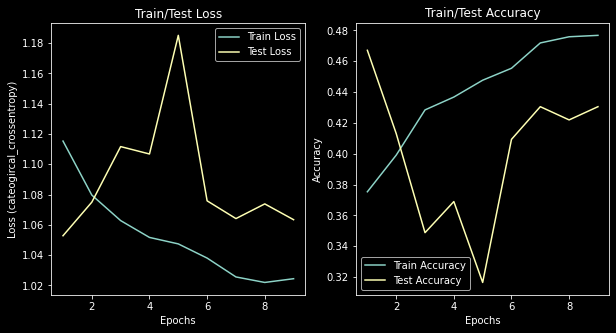

In [6]:
Viz.plot_loss_accuracy(mobilenet_history, 'dark_background')

In [ ]:
y_test_prob = [np.argmax(i) for i in mobilenet.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in mobilenet.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

#this function creates a confusion matrix given the confusion matrixes of test and train
Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Mask', 'Mask'], theme = 'dark_background')

In [ ]:
assert False

In [ ]:

%%javascript
IPython.notebook.save_notebook()

In [ ]:
os.system(r'%windir%\system32\rundll32.exe powrprof.dll,SetSuspendState Hibernate')